# Prepare IAM Dataset

In [1]:
import numpy as np
import os
import torch
import torchtext
from matplotlib import pyplot
iam_dir = "data/iam/"
char_dict = {k:v for v,k in enumerate(' !"#%&\'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz')}
inv_char_dict = {v:k for k,v in char_dict.items()}
n_chars = len(char_dict)
import utils_iam

In [2]:
orig_trainset = [l.strip() for l in open(os.path.join(iam_dir, "trainset.txt"))]
orig_testset_v = [l.strip() for l in open(os.path.join(iam_dir, "testset_v.txt"))] # smallest
orig_testset_f = [l.strip() for l in open(os.path.join(iam_dir, "testset_f.txt"))]
orig_testset_t = [l.strip() for l in open(os.path.join(iam_dir, "testset_t.txt"))]

trainset = orig_trainset + orig_testset_f + orig_testset_t
validset = orig_testset_v

In [3]:
training_samples = utils_iam.process_set(trainset, iam_dir)
#torch.save(training_samples, "preprocessed-training.pt")
val_samples = utils_iam.process_set(validset, iam_dir)
#torch.save(val_samples, "preprocessed-validation.pt")

100%|██████████| 192/192 [00:06<00:00, 29.36it/s]


#### Get Mean and Standard deviation

In [4]:
x = torch.cat([d["rel_strokes"] for d in training_samples.values()], dim=0)
mean,std = x[:,:2].mean(0),x[:,:2].std(0)
print ("mean", mean, "std", std)

mean tensor([8.1842, 0.1145]) std tensor([40.3660, 37.0441])


#### Process Data
We use a torchtext dataset to use our preprocessed IAM online handwriting data.

In [5]:
class DS(torchtext.data.Dataset):
    def __init__(self, samples, mean, std):
        self.myfields = [('txt',torchtext.data.Field(use_vocab=True,tokenize=list, eos_token='<eos>')), 
                         ('txtn',torchtext.data.Field(use_vocab=False,pad_token=0)), 
                         ('txtlen',torchtext.data.Field(use_vocab=False)),
                         ('txtmask',torchtext.data.Field(use_vocab=False,pad_token=0, dtype=torch.float)),
                         ('xs',torchtext.data.Field(use_vocab=False, pad_token=-1, dtype=torch.float)),
                         ('ys',torchtext.data.Field(use_vocab=False, pad_token=-1, dtype=torch.float)),
                         ('pen',torchtext.data.Field(use_vocab=False,pad_token=-1)),
                         ('ptslen',torchtext.data.Field(use_vocab=False))
                        ]
        self.coord_mean = mean
        self.coord_std  = std
        examples = []
        for s in samples.values():
            txt = [c for c in s["txt"] if c in char_dict]
            txtn = torch.LongTensor([char_dict[i] for i in txt])
            txtlen = torch.LongTensor([len(txt)])
            txtmask = torch.ones(len(txt))
            stroke = s['rel_strokes']
            xs = stroke[:,0]
            ys = stroke[:,1]
            pen = stroke[:,2]
            ptslen = torch.LongTensor([len(pen)])
            if xs.abs().max()<1000 and ys.abs().max()<1000 and len(txt)>=20:
                xs = (xs-self.coord_mean[0])/self.coord_std[0]
                ys = (ys-self.coord_mean[1])/self.coord_std[1]
                examples.append(torchtext.data.Example.fromlist([txt, txtn, txtlen, txtmask,
                                                            xs, ys, pen, ptslen
                                                            ], self.myfields))        
        super(DS, self).__init__(examples, self.myfields)
        self.myfields[0][1].build_vocab(self)
    def sort_key(self, ex):
        return len(ex.txt)
    def tensor_to_str(self,t):
        return ''.join([self.fields['txt'].vocab.itos[c] for c in t if c >= 3])
    def tensor_to_str2(self,t):
        return ''.join([inv_char_dict[c] for c in t])

#### Load training/validation

In [6]:
train_ds = DS(training_samples, mean, std)
val_ds   = DS(val_samples, mean, std)

train_it, = torchtext.data.BucketIterator.splits((train_ds,), batch_size=10, repeat=False)
val_it,   = torchtext.data.BucketIterator.splits((val_ds,),   batch_size=10, repeat=False)

'Mr . Macleod went on with the conference'

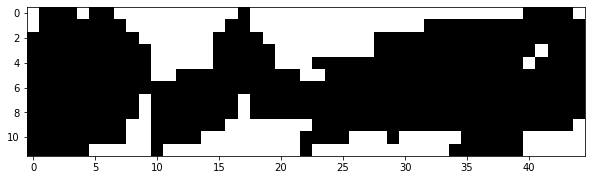

In [7]:
b = train_ds[1]
pts = torch.stack([b.xs,b.ys,b.pen.float()],dim=-1)
pyplot.figure(figsize=(10,5))
pyplot.imshow(utils_iam.stroke_to_image(pts[:b.ptslen[0]].cpu()), cmap=pyplot.cm.gray)
''.join(b.txt)

In [8]:
import model
n_hidden = 900
n_mixt_attention = 10
n_mixt_output = 20
batch_size = 50

handwriting_gen = model.HandwritingModel(n_hidden, n_chars, n_mixt_attention, n_mixt_output)
print(handwriting_gen)

HandwritingModel(
  (attention): Attention(
    (linear): Linear(in_features=900, out_features=30, bias=True)
  )
  (rnn_cell): RNNCell(
    (cell): LSTMCell(84, 900)
  )
  (mixture): MixtureGaussians2DandPen(
    (linear): Linear(in_features=981, out_features=121, bias=True)
  )
)


In [12]:
weights = utils_iam.load_from_hdf5('pretrained_weights/graves_handwriting_generation_2018-03-13-02-45epoch_49.hd5')
for n,p in handwriting_gen.named_parameters():
        p.data.copy_(torch.from_numpy(weights[n]))
handwriting_gen.cuda()

['attention.linear.bias', 'attention.linear.weight', 'mixture.linear.bias', 'mixture.linear.weight', 'rnn_cell.cell.bias_hh', 'rnn_cell.cell.bias_ih', 'rnn_cell.cell.weight_hh', 'rnn_cell.cell.weight_ih']


HandwritingModel(
  (attention): Attention(
    (linear): Linear(in_features=900, out_features=30, bias=True)
  )
  (rnn_cell): RNNCell(
    (cell): LSTMCell(84, 900)
  )
  (mixture): MixtureGaussians2DandPen(
    (linear): Linear(in_features=981, out_features=121, bias=True)
  )
)

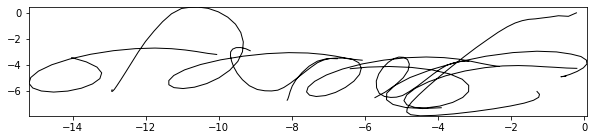

In [23]:
i = next(iter(train_it))
i_seq_pt = torch.stack([i.xs, i.ys, i.pen.float()], dim=2).cuda()
i_seq_pt = i_seq_pt[:-1].cuda()
i_seq_str = torch.autograd.Variable(torch.LongTensor([int(char_dict[c]) for c in "Leonardo "]).view(-1,1).cuda())
i_seq_str_mask = torch.autograd.Variable(torch.ones(i_seq_str.size()).cuda())
seq_pt, seq_mask = handwriting_gen.predict(i_seq_pt[0,:1], i_seq_str, i_seq_str_mask, bias=50)

lengths = seq_mask.sum(0).data.long()
idx = 0
pyplot.figure(figsize=(10,2))
utils_iam.show_stroke(seq_pt.data.cpu()[:lengths[idx],idx])
#''.join([inv_char_dict[c] for c in i_seq_str.data.cpu()[:,idx]])
pyplot.show()